In [1]:
!pip install kikuchipy
!pip install import-ipynb

import import_ipynb
import impAt as at
import re
import torch 
import torch.utils.data as tor_utils
import os
import torch.nn as nn
import torchvision.transforms as transforms
import random
import torchvision.models as torchmodels
import torchvision

import numpy as np

from fastai import *
from fastai.vision.all import *
from fastai.data.core import DataLoaders as fast_dataloaders
from orix.quaternion import Rotation, Symmetry
import kikuchipy as kp
import orix

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import time
import math

from fastai.losses import BaseLoss
import torch.nn.functional as F
from fastai.vision.all import *
from orix import sampling, plot, io
from orix.vector import Vector3d

import random
from torchvision.transforms.functional import to_pil_image

importing Jupyter notebook from impAt.ipynb


In [2]:
#Set the initial electron microscope energy value to 20kV
energy = 20

#Load in a nickel EBSD  master pattern with specified parameters
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert", energy = energy)

#Get the point group symmetry of the master pattern
sym = mp.phase.point_group

#Set the size of the image to be generated
imgSize = 60

#Initialise an EBSD detector with specific settings
detector = kp.detectors.EBSDDetector(shape = (imgSize, imgSize), sample_tilt = 70, pc = [0.421, 0.7794, 0.5049], convention = "edax")

#Define a batch size for training
batchSize = 320

#Initialise an object using the previously obtained symmetry information to return symmetrical labels
breakdown = at.SymQuatBreakdown(sym)

In [3]:
#Get the phase information from the master pattern
ni = mp.phase

#Generate sample rotations using a specified method and resolution
sampleRot = sampling.get_sample_fundamental(method="cubochoric", resolution=1, point_group=ni.point_group)

#Determine the number of training samples
numTrain = sampleRot.shape[0]

#Create a tensor for labels initialized with zeros
labels = torch.zeros((numTrain, 96, 4))

#Loop through each training sample and generate its labels
for i in range(numTrain):
    labels[i, :, :] = breakdown.breakdown(sampleRot.data[i, :])

#Generate simulated EBSD patterns for training data
sim = mp.get_patterns(rotations=sampleRot, detector=detector, energy=energy, dtype_out=np.float32, compute=True)

#Convert the simulated patterns to a torch tensor
imgs = torch.tensor(sim.data).unsqueeze(1)

#Sett the number of validation samples
num = 100000

#Generate random grain rotations for validation
grains = np.deg2rad(np.random.rand(num, 3) * 720 - 360)
valSampleRot = Rotation.from_euler(grains)

#Determine the number of validation samples
numVal = valSampleRot.shape[0]

#Create a tensor for validation labels initialized with zeros
valLabels = torch.zeros((numVal, 96, 4))

#Loop through each validation sample and generate its labels
for i in range(numVal):
    valLabels[i, :, :] = breakdown.breakdown(valSampleRot.data[i, :])

#Generate simulated EBSD patterns for validation data
valSim = mp.get_patterns(rotations=valSampleRot, detector=detector, energy=energy, dtype_out=np.float32, compute=True)

#Convert the simulated validation patterns to a torch tensor
valImgs = torch.tensor(valSim.data).unsqueeze(1)

[########################################] | 100% Completed | 30.17 s
[########################################] | 100% Completed | 3.85 ss


In [4]:
#Initialise a transformation to set NaN values to zero
nanFilter = at.setNaNToZero()

#Set parameters for color jittering
brightness = 0.999
contrast = brightness
saturation = brightness
hue = brightness / 2

#Initialise various image augmentation transformations using standard torchvision transforms
sharp = transforms.RandomAdjustSharpness(2, p=0.5)
autocontrast = transforms.RandomAutocontrast(p=0.5)
equalise = transforms.RandomEqualize(p=0.5)
augMix = transforms.AugMix(5, all_ops=False)

jitter = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
valJitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2)

erase = transforms.RandomErasing()

#Define lists of transformations for training and validation, using above transforms
trainTransformList = [jitter, sharp, autocontrast, equalise]
valTransformList = [jitter, sharp, autocontrast, equalise]

#Define a wapper function to apply random transformations with probability p
def randomTransform(transform, p=0.5):
    return transforms.RandomApply([transform], p=p)

#Apply a random chance of activation to the list of transforms
trainTransformList = [randomTransform(i) for i in trainTransformList]

#Consolidate standard torchvision transforms to a single transform 
trainTransform = at.mixedTransform(trainTransformList)
valTransform = at.mixedTransform(valTransformList)

#Initialise noise and brightness related transformations for training and validation
trainNoise = at.AddNoise(0.2)
valNoise = at.AddNoise(0.1)

trainBright = at.Bright(5)
valBright = at.Bright(1)

trainBrightNoise = at.BrightNoise(0.25)
valBrightNoise = at.BrightNoise(0.1)

#Initialise a random blur transformation
randBlur = at.randomBlur(3)

#Initialise normalisation transformation
Norm = at.Normalise()

#Initialise circular crop transformations
CircCrop = at.RandCircularCrop(radius=20)
StdCrop = at.CircularCrop()

#Initialise add and scale transformations
add = at.addTo()
scale = at.scaleBy()

#Initialise zoom and stetch transformations
stretcher = at.StretchAndCropTransform(1.3, 1.3, 60)
zoomTmf = at.zoom(1.3, 60)

#Create a list of transformations for training data with random application
tmfs = [Norm, trainTransform, randBlur, Norm, trainBright, trainBrightNoise, trainNoise, Norm, CircCrop, add, scale, nanFilter]
tmfs = [randomTransform(i, 0.75) for i in tmfs]

#Remove random chance from the nanFilter
tmfs[-1] = nanFilter

#Create a list of transformations for validation data
valTmfs = [Norm, valTransform, randBlur, Norm, valBright, valBrightNoise, valNoise, Norm, StdCrop, nanFilter]

torch.Size([60, 60])
tensor(2.2775)
tensor(0.4700)


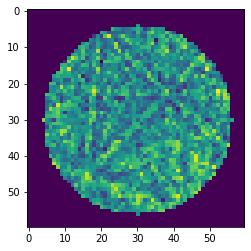

torch.Size([60, 60])
tensor(0.0461)
tensor(-0.9530)


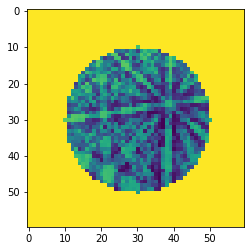

torch.Size([60, 60])
tensor(0.8483)
tensor(0.)


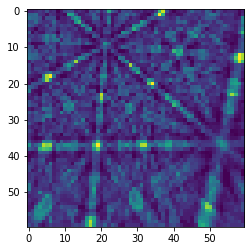

torch.Size([60, 60])
tensor(0.9788)
tensor(-0.0212)


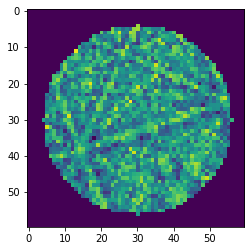

torch.Size([60, 60])
tensor(2.1377)
tensor(0.4413)


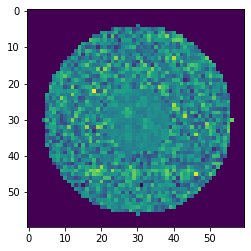

torch.Size([60, 60])
tensor(0.9224)
tensor(0.0857)


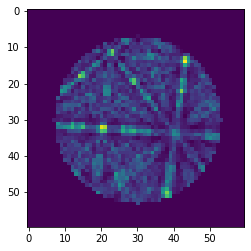

torch.Size([60, 60])
tensor(1.2620)
tensor(0.1909)


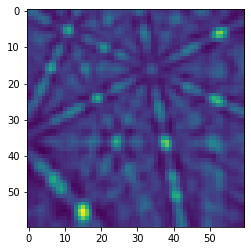

torch.Size([60, 60])
tensor(1.9076)
tensor(-0.0225)


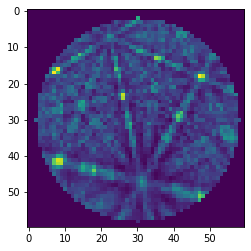

torch.Size([60, 60])
tensor(0.7609)
tensor(-0.0564)


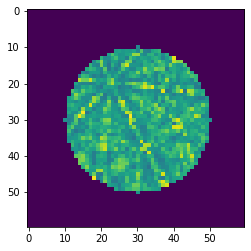

torch.Size([60, 60])
tensor(1.7316)
tensor(-0.2468)


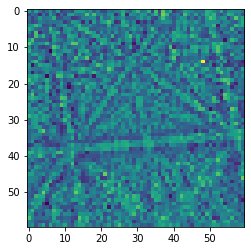

torch.Size([60, 60])
tensor(1.)
tensor(0.)


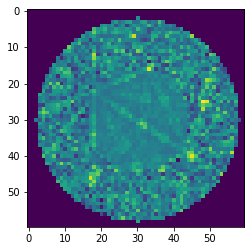

torch.Size([60, 60])
tensor(1.3356)
tensor(-0.6673)


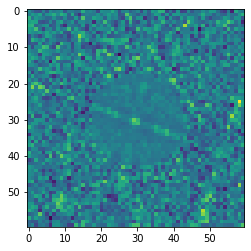

torch.Size([60, 60])
tensor(1.1169)
tensor(0.1619)


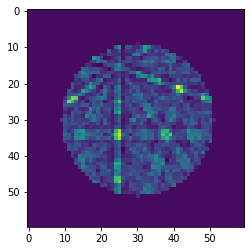

torch.Size([60, 60])
tensor(1.9937)
tensor(0.)


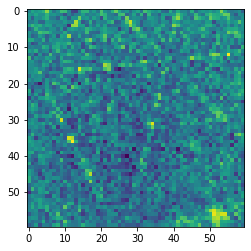

torch.Size([60, 60])
tensor(-0.0552)
tensor(-6.3108)


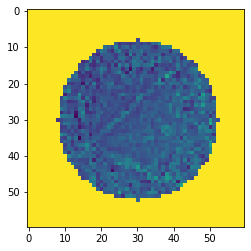

torch.Size([60, 60])
tensor(1.1321)
tensor(-0.0648)


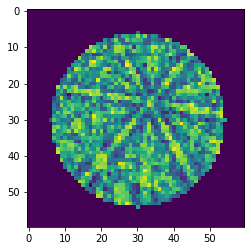

torch.Size([60, 60])
tensor(1.)
tensor(0.)


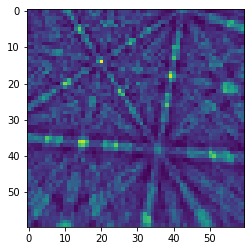

torch.Size([60, 60])
tensor(1.0949)
tensor(0.1574)


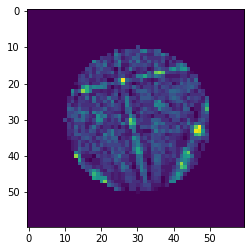

torch.Size([60, 60])
tensor(0.0741)
tensor(-5.0393)


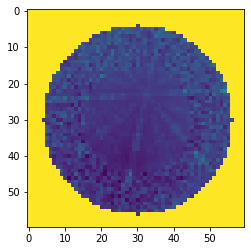

torch.Size([60, 60])
tensor(0.7661)
tensor(-0.2339)


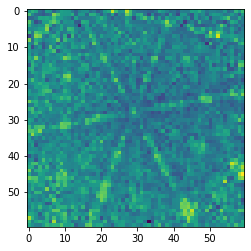

In [5]:
#Create a training and validation dataset using the simulated data
data = at.greyDataset(imgs, labels, tmfs)
valData = at.greyDataset(valImgs, valLabels, valTmfs)

#Create fast ai data loader
fastDls = fast_dataloaders.from_dsets(data, valData, batch_size = batchSize, device = "cuda", shuffle = True, num_workers=12, prefetch_factor=1000)

#Get a single batch of data from the data loader
x = fastDls.one_batch()

#Extract the images from the batch
data = x[0]

#Loop through the first 20 images in the batch
for i in range(20):
    #Extract the image data to CPU
    img = data[i, 0, :, :].cpu()
    
    #Print the shape of the image tensor
    print(img.shape)
    
    #Print the maximum and minimum pixel values in the image tensor
    print(torch.max(img))
    print(torch.min(img))
    
    #Display the image
    plt.imshow(img)
    plt.show()

In [6]:
#Initialising and renaming loss functions defined in impAt
l1Simple = at.l1Simple
l1Simple.__name__ = "L1 Simple"

L1Sym = at.l1Sym
L1Sym.__name__ = "L1 Sym"

rotDistance = at.trueRotDistance
rotDistance.__name__ = "Rotation Distance"

mixedLoss = at.mixedLoss
mixedLoss.__name__ = "Mixed Loss"

#Defining a list of callbacks to be applied during training
accumulationSteps = 50
cbs = [GradientAccumulation(n_acc=accumulationSteps)]

In [7]:
#Set the dropout rate for both convolutional and linear layers
ConvDropOut = 0.5
linDropOut = 0.5

#Define the architecture of the model to be a custom resnet 50 based architecture and outputting only quaternions
arch = at.DeepGreyResnet50(4, ConvDropOut, linDropOut)

#Create a fastai learner for training
learn = Learner(fastDls, arch, l1Simple, metrics=[rotDistance, L1Sym])

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Train using one cycle lr scheduling
learn.fit_one_cycle(10, cbs = cbs)
#learn.save("N1")

epoch,train_loss,valid_loss,Rotation Distance,L1 Sym,time


In [ ]:
#Further model training

#learn.lr_find()
learn.fit_one_cycle(100, start_epoch = 70, cbs = cbs)
learn.save("N5")

#n3 normal
#n4 dropout
#n5 dropouit no zooms